In [1]:
import pandas
import datetime
import numpy
from aacgmv2 import convert_mlt, convert
from pyigrf12 import gridigrf12
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2500.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 25
perCutoffMLTMLAT = 0.15
mlatCutOffUpper = 65.
mlatCutOffLower = 53.
cutOffMLTMLATUniqCnt = 4
delLatDist = 111. * 1e3 # 1 deg lat is 111 km
selTimeStart = datetime.datetime( 2013,3,1,4,0 )
selTimeEnd = datetime.datetime( 2013,3,1,6,0 )

In [3]:
# READ Dst and AE data
inpDstFile = "../data/dst_out_file.csv"
dstDF = pandas.read_csv(inpDstFile, sep=' ',\
                infer_datetime_format=True,\
                        parse_dates=["dst_date"])
dstDF = dstDF[ (dstDF["dst_date"] > datetime.datetime(2010,12,31)) &\
             (dstDF["dst_date"] < datetime.datetime(2015,1,1))].reset_index(drop=True)
dstDF = dstDF[ dstDF["dst_index"] <= 10. ].reset_index(drop=True)
dstDF["dtStr"] = dstDF["dst_date"].apply(lambda x: x.strftime('%Y%m%d'))
dstDF["hour"] = dstDF["dst_date"].apply(lambda x: x.strftime('%H'))
# Aur Inds
aurDF = pandas.read_csv( "../data/aur_processed.txt", sep=' ' )
aurDF["date"] = pandas.to_datetime(aurDF["datetimeStr"], format='%Y%m%d-%H-%M')
aurDF["hour"] = aurDF["date"].apply(lambda x: x.strftime('%H'))
aurDF["minute"] = aurDF["date"].apply(lambda x: x.strftime('%M'))
aurDF["dtStr"] = aurDF["date"].apply(lambda x: x.strftime('%Y%m%d'))

In [4]:
fitVelFile = "../data/fitres-fin-20130301.csv"
inpColNames = ["azim", "azimStd", "delMLT", "goodFit",\
           "MLAT", "normMLT", "vSaps", "velSTD",\
           "endPtMLAT", "endPtNormMLT", "date"]
velsDataDF = pandas.read_csv(fitVelFile, sep=' ',\
                             header=None, names=inpColNames,\
                            infer_datetime_format=True,\
                            parse_dates=["date"])

velsDataDF["dtStr"] = velsDataDF["date"].apply(lambda x: x.strftime('%Y%m%d'))
# Discard unwanted values
# We'll only consider those velocities 
# which lie between 0 and 2500 m/s
# and located below 70 MLAT
velsDataDF = velsDataDF[ (velsDataDF["vSaps"] > velCutoffLower) \
                        & (velsDataDF["vSaps"] < velCutoffUpper)\
                       ].reset_index(drop=True)
velsDataDF = velsDataDF[ (velsDataDF["MLAT"] < mlatCutOffUpper) &\
                       (velsDataDF["MLAT"] > mlatCutOffLower) ].reset_index(drop=True)
velsDataDF["hour"] = velsDataDF["date"].apply(lambda x: x.strftime('%H'))
velsDataDF["minute"] = velsDataDF["date"].apply(lambda x: x.strftime('%M'))
# Now merge the dst and velocity DFs
velsDataDF = pandas.merge( velsDataDF, dstDF,\
                          on=["dtStr", "hour"], how='inner' )
# We generally work with Dst bins, set them up
# add dst_bins
dstBins = [ -150, -75, -50, -25, -10, 10 ]
velsDataDF = pandas.concat( [ velsDataDF, \
                    pandas.cut( velsDataDF["dst_index"], \
                               bins=dstBins ) ], axis=1 )
velsDataDF.columns = ["azim", "azimStd", "delMLT", "goodFit",\
               "MLAT", "normMLT", "vSaps", "velSTD",\
               "endPtMLAT", "endPtNormMLT", "date",\
                'dtStr', 'hour', 'minute', 'dst_date',\
                'dst_index', 'dst_bin']
# Also merge with aurDF
# print "pre merge shape-->", velsDataDF.shape
velsDataDF = pandas.merge( velsDataDF, aurDF,\
                         on=["dtStr", "hour", "minute"], how='inner')
selColsVels = ["azim", "azimStd", "delMLT", "goodFit",\
               "MLAT", "normMLT", "vSaps", "velSTD",\
               "endPtMLAT", "endPtNormMLT", "date_x",\
                'dtStr', 'hour', 'minute', 'dst_date',\
                'dst_index', 'dst_bin', 'datetimeStr', 'AE', 'AL', 'AO', 'AU']
velsDataDF = velsDataDF[ selColsVels ]
velsDataDF.columns = ["azim", "azimStd", "delMLT", "goodFit",\
               "MLAT", "normMLT", "vSaps", "velSTD",\
               "endPtMLAT", "endPtNormMLT", "date",\
                'dtStr', 'hour', 'minute', 'dst_date',\
                'dst_index', 'dst_bin', 'datetimeStr', 'AE', 'AL', 'AO', 'AU']

In [5]:
dstSapsMLTLatCountDF = velsDataDF.groupby(["dst_bin", "normMLT", "MLAT"]).size().reset_index()
maxCntMLTLatDst = dstSapsMLTLatCountDF.groupby(["dst_bin"]).max().reset_index()
maxCntMLTLatDst = maxCntMLTLatDst.drop(["normMLT", "MLAT"], 1)
maxCntMLTLatDst.columns = ["dst_bin", "maxCount"]
dstSapsMLTLatCountDF = pandas.merge( dstSapsMLTLatCountDF, maxCntMLTLatDst, \
                              on=["dst_bin"], how='inner')
dstSapsMLTLatCountDF.columns = ["dst_bin", "normMLT", "MLAT", "count", "maxCount"]
dstSapsMLTLatCountDF["probOcc"] = dstSapsMLTLatCountDF["count"]/dstSapsMLTLatCountDF["maxCount"]
# Filter out unwanted values
dstSapsMLTLatCountDF = dstSapsMLTLatCountDF[ \
                        dstSapsMLTLatCountDF["probOcc"] >= perCutoffMLTMLAT\
                        ].reset_index(drop=True)
velsDataDF = pandas.merge( velsDataDF, dstSapsMLTLatCountDF,\
                          on=["dst_bin", "normMLT", "MLAT"], how='inner' )
velsDataDF["azim"] = -90.-velsDataDF["azim"]
velsDataDF.head()

,azim,azimStd,delMLT,goodFit,MLAT,normMLT,vSaps,velSTD,endPtMLAT,endPtNormMLT,...,dst_index,dst_bin,datetimeStr,AE,AL,AO,AU,count,maxCount,probOcc
0,-66.561830,0.492225,0.5,True,61.5,-3.0,163.927429,1.953576,61.57,-3.15,...,-21.0,"(-25, -10]",20130301-04-22,180,-47,43,133,50,69.0,0.724638
1,-69.999337,0.534355,0.5,True,61.5,-3.0,176.111024,2.557273,61.56,-3.17,...,-21.0,"(-25, -10]",20130301-04-24,171,-46,40,125,50,69.0,0.724638
2,-69.267676,2.301832,1.0,True,61.5,-3.0,163.015060,5.685681,61.56,-3.15,...,-21.0,"(-25, -10]",20130301-04-26,178,-50,39,128,50,69.0,0.724638
3,-81.303239,1.319474,0.5,True,61.5,-3.0,169.444380,4.637597,61.53,-3.17,...,-21.0,"(-25, -10]",20130301-04-28,166,-50,33,116,50,69.0,0.724638
4,-83.089589,0.356646,1.0,True,61.5,-3.0,161.630477,1.413341,61.52,-3.16,...,-21.0,"(-25, -10]",20130301-04-30,156,-53,25,103,50,69.0,0.724638


In [6]:
def get_geo_coords(row):
    if row["normMLT"] < 0: 
        currMLT = row["normMLT"] + 24.
    else:
        currMLT = row["normMLT"]
    currMlon = convert_mlt( currMLT, row["date"] , m2a=True )
    glat, glon = convert( row["MLAT"], currMlon , 300, row["date"], a2g=True)
    return str(glat) + "__" + str(glon)

velsDataDF["gcoord"] = velsDataDF.apply( get_geo_coords, axis=1 )
velsDataDF["glat"] = [ float( x.split("__")[0] ) for x in velsDataDF["gcoord"] ]
velsDataDF["glon"] = [ float( x.split("__")[1] ) for x in velsDataDF["gcoord"] ]

In [7]:

def get_efield(row):
    Bx,By,Bz,Bf, yeardec = gridigrf12( row["date"], 0, 1, 300., row["glat"], row["glon"] )
    Vy = row["vSaps"] * numpy.round( numpy.sin(numpy.deg2rad( row["azim"] )), 2 )
    Vx = row["vSaps"] * numpy.round( numpy.cos(numpy.deg2rad( row["azim"] )), 2 )
    Vz = 0.
    Ex = Bz[0] * -1 * Vy * 1e-9 # nT
    Ey = Bz[0] * Vx * 1e-9 # nT
    Ez = Bx[0] * Vy * 1e-9 - By[0] * Vx * 1e-9 # nT
    # Round electric fields by 2
    Ex = numpy.round( Ex * 1e3 , 4 ) # mV/m
    Ey = numpy.round( Ey * 1e3 , 4 ) # mV/m
    Ez = numpy.round( Ez * 1e3 , 4 ) # mV/m
    return str(Ex) + "__" + str(Ey) + "__" + str(Ez)

velsDataDF["Efield"] = velsDataDF.apply( get_efield, axis=1 )
velsDataDF["Ex"] = [ float( x.split("__")[0] ) for x in velsDataDF["Efield"] ]
velsDataDF["Ey"] = [ float( x.split("__")[1] ) for x in velsDataDF["Efield"] ]
velsDataDF["Ez"] = [ float( x.split("__")[2] ) for x in velsDataDF["Efield"] ]
velsDataDF["Efield"] = numpy.sqrt( numpy.square(velsDataDF["Ex"]) +\
                                 numpy.square(velsDataDF["Ey"]) +\
                                 numpy.square(velsDataDF["Ez"]))

In [8]:
# velsDataDF = velsDataDF[ (velsDataDF["date"] >= selTimeStart) &\
#                        (velsDataDF["date"] <= selTimeEnd) ]
# print velsDataDF[ ["vSaps", "dtStr", "date"] ]

In [9]:
mltVelsVarsDF = velsDataDF[ ["normMLT", "MLAT", "vSaps", "Efield"] \
                    ].groupby( ["normMLT", "MLAT"] ).mean().reset_index()
mltVelsVarsDF.columns = ["normMLT", "MLAT", "mean_vel", "mean_efld"]
stdVelsVarsDF = velsDataDF[ ["normMLT", "MLAT", "vSaps", "Efield"] \
                    ].groupby( ["normMLT", "MLAT"] ).std().reset_index()
stdVelsVarsDF.columns = ["normMLT", "MLAT", "std_vel", "std_efld"]
mltVelsVarsDF = pandas.merge( mltVelsVarsDF, stdVelsVarsDF, on=["normMLT", "MLAT"] )
mltVelsVarsDF = mltVelsVarsDF.dropna().reset_index(drop=True)
mltVelsVarsDF.head()

,normMLT,MLAT,mean_vel,mean_efld,std_vel,std_efld
0,-5.0,62.0,606.953873,30.211806,144.369794,7.219293
1,-5.0,62.5,335.616162,16.723021,253.784441,12.755785
2,-5.0,63.0,424.098497,21.188895,266.816925,13.448931
3,-5.0,63.5,205.570106,10.223389,58.845204,2.907585
4,-5.0,64.0,252.282736,12.548873,82.406192,4.082258


In [10]:
# Arrays to store potential
potBinArr = []
potNrmMltArr = []
potMlatArr = []
potPotArr = []

for cmlt in mltVelsVarsDF["normMLT"].unique().tolist():
    # Get Uniq Lats at the MLT!
    selMltDF = mltVelsVarsDF[ mltVelsVarsDF["normMLT"] == cmlt ]
    # At each MLT we assume potential is zero at the lowest
    # latitude!
    prevPot = 0
    for cMlat in sorted( selMltDF["MLAT"].unique().tolist() ):
        selLatsDF = selMltDF[ (selMltDF["MLAT"] == cMlat) ]
        # Remember we have 0.5 deg latitude res
        # so we take delLatDist/2
        potLat = selLatsDF[ selLatsDF["MLAT"] == cMlat ]["mean_efld"] * delLatDist/2. * 1e-3 * 1e-3 # kV
        currPot = prevPot - potLat.values[0]
        prevPot = currPot
        potNrmMltArr.append( cmlt )
        potMlatArr.append( cMlat )
        potPotArr.append( round(currPot,2) )
        
potentialDF = pandas.DataFrame({
            "normMLT" : potNrmMltArr,
            "MLAT" : potMlatArr,
            "potential" : potPotArr
            })
potentialDF.head()

,MLAT,normMLT,potential
0,62.0,-5.0,-1.68
1,62.5,-5.0,-2.60
2,63.0,-5.0,-3.78
3,63.5,-5.0,-4.35
4,64.0,-5.0,-5.04


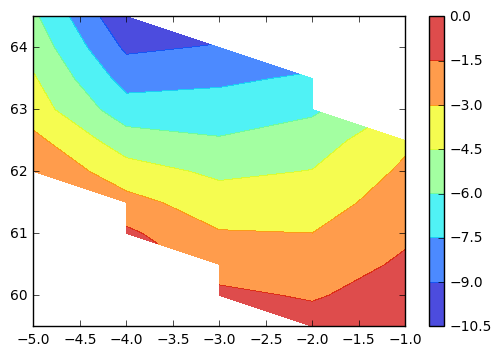

In [11]:
testDF = potentialDF[ ["MLAT", "normMLT", "potential"] ].pivot( "MLAT", "normMLT" )
# testDF = testDF.fillna(0.)
Y = testDF.index.values
X = testDF.columns.levels[1].values
Z=testDF.values
Xi,Yi = numpy.meshgrid(X, Y)
plt.contourf(Xi, Yi, Z, alpha=0.7, cmap=plt.cm.jet);
plt.colorbar()

In [13]:
potentialDF["MLT"] = [ x+24. if x < 0. else x for x in potentialDF['normMLT']]

potentialDF.to_csv("../data/sapsPotentials-20130301.txt", sep=' ',\
                   index=False, columns=[ "MLT", "MLAT", "potential" ], header=False)
